In [42]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# general data processing
import pandas as pd
import numpy as np

# text processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ML modeling
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

In [32]:
df_train = pd.read_csv("./learn-ai-bbc/BBC News Train.csv")
df_test = pd.read_csv("./learn-ai-bbc/BBC News Test.csv")
df_sample_solution = pd.read_csv("./learn-ai-bbc/BBC News Sample Solution.csv")

In [33]:
df_train.columns

Index(['ArticleId', 'Text', 'Category'], dtype='object')

In [34]:
np.unique(df_train.Category)

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [35]:
df_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [36]:
df_train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

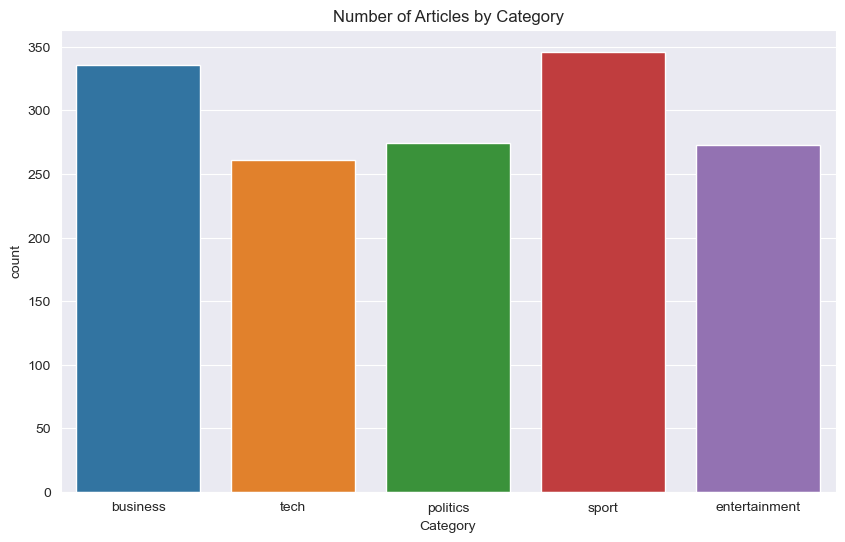

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x="Category")
plt.title("Number of Articles by Category")
plt.show()

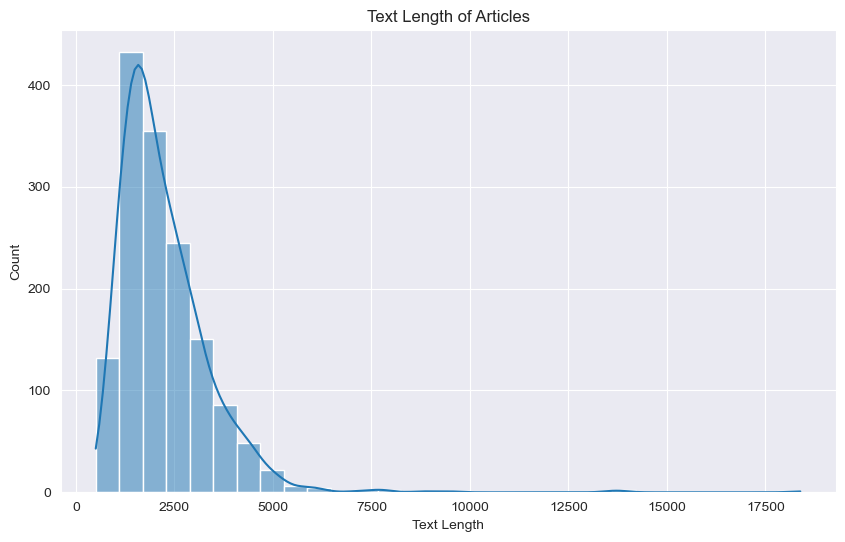

In [38]:
df_train["Text Length"] = df_train["Text"].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x="Text Length", bins=30, kde=True)
plt.title("Text Length of Articles")
plt.show()

In [41]:
# if nltk package is not installed, run the following commands
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")

def clean_text(text):
    # remove punctuation and numbers
    text = re.sub("[^a-zA-Z]", " ", text)
    # convert text to lowercase
    text = text.lower()
    # remove stop words
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    # lemmatize the words
    cleaned_text = " ".join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])
    return cleaned_text

df_train["Cleaned_Text"] = df_train["Text"].apply(clean_text)

In [52]:
def train_evaluate_unsupervised_models(X_data, y_data, fractions):
    results = []
    for frac in fractions:
        X_train_frac, X_val, y_train_frac, y_val = train_test_split(X_data, y_data, train_size=frac)
        nmf_model = NMF(n_components=5)
        W_train = nmf_model.fit_transform(X_train_frac)
        W_val = nmf_model.transform(X_val)
        topic_category_mapping = np.argmax(W_train.T @ np.eye(len(np.unique(y_train_frac)))[y_train_frac], axis=1)
        dominant_topics_val = np.argmax(W_val, axis=1)
        predicted_categories = topic_category_mapping[dominant_topics_val]
        predicted_labels = label_encoder.inverse_transform(predicted_categories)
        accuracy = accuracy_score(y_val, predicted_categories)
        results.append((frac, accuracy))
        
    return results

In [55]:
# function to integrate training models and returning their accuracies
def train_evaluate_supervised_models(X_data, y_data, fractions):
    results = []
    for frac in fractions:
        X_train_frac, X_val, y_train_frac, y_val = train_test_split(X_data, y_data, train_size=frac)
        svm_model = SVC()
        rf_model = RandomForestClassifier(n_estimators=100)
        svm_model.fit(X_train_frac, y_train_frac)
        rf_model.fit(X_train_frac, y_train_frac)
        y_pred_svm = svm_model.predict(X_val)
        y_pred_rf = rf_model.predict(X_val)
        
        accuracy_svm = accuracy_score(y_val, y_pred_svm)
        accuracy_rf = accuracy_score(y_val, y_pred_rf)
        
        results.append((frac, accuracy_svm, accuracy_rf))
    return results

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [57]:
# encode the labels to numbers
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(df_train['Category'])
# vectorize the cleaned texts
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['Cleaned_Text'])

fractions = [0.1, 0.2, 0.5, 0.8]
results = train_evaluate_unsupervised_models(tfidf_matrix, numerical_labels, fractions)
for frac, accuracy in results:
    print(f"Fraction: {frac*100}% - Accuracy: {accuracy:.4f}")

Fraction: 10.0% - Accuracy: 0.8770
Fraction: 20.0% - Accuracy: 0.8784
Fraction: 50.0% - Accuracy: 0.8953
Fraction: 80.0% - Accuracy: 0.8893


In [58]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df_train["Cleaned_Text"])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train["Category"])
fractions = [0.1, 0.2, 0.5, 0.8]
results = train_evaluate_supervised_models(X_tfidf, y_encoded, fractions)
for frac, accuracy_svm, accuracy_rf in results:
    print(f"Fraction: {frac*100}% - SVM Accuracy: {accuracy_svm:.4f}, Random Forest Accuracy: {accuracy_rf:.4f}")

Fraction: 10.0% - SVM Accuracy: 0.9247, Random Forest Accuracy: 0.9150
Fraction: 20.0% - SVM Accuracy: 0.9362, Random Forest Accuracy: 0.9220
Fraction: 50.0% - SVM Accuracy: 0.9557, Random Forest Accuracy: 0.9383
Fraction: 80.0% - SVM Accuracy: 0.9463, Random Forest Accuracy: 0.9430
